# Marketing Mediation Analysis: OLS vs Bayesian Approaches

**Objective**: Compare classical OLS and Bayesian approaches for estimating direct and indirect effects in a marketing attribution scenario.

## Causal Structure (DAG)

```
Seasonality → Brand Search
Seasonality → TV  
Seasonality → Sales
TV → Brand Search
TV → Sales
Brand Search → Sales
```

**Research Question**: What portion of TV's effect on Sales is mediated through Brand Search?

**Key Quantities**:
- **Direct Effect**: TV → Sales (γ3)
- **Indirect Effect**: TV → Brand Search → Sales (β2 × γ1)
- **Total Effect**: Direct + Indirect

---

## Setup and Dependencies

In [1]:
# Standard library
import json
import warnings
from pathlib import Path

# Data manipulation and computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Bayesian modeling
import pymc as pm
import arviz as az

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
DATA_DIR = Path('../data')
DATA_DIR.mkdir(exist_ok=True)

print("Dependencies loaded successfully")
print(f"NumPy: {np.__version__}")
print(f"PyMC: {pm.__version__}")
print(f"ArviZ: {az.__version__}")

/home/miguel/agentic_projects/agents_ds_team/.venv/lib/python3.12/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Dependencies loaded successfully
NumPy: 2.3.5
PyMC: 5.27.1
ArviZ: 0.23.4


---
## Section 1: Data Simulation

We'll generate synthetic data based on the causal structure with known ground truth parameters.

In [2]:
# Ground truth parameters for data generation
true_params = {
    # TV equation: TV ~ Seasonality
    'tv_seasonality': 1.5,
    'tv_sigma': 0.5,
    
    # Brand Search equation: Brand Search ~ Seasonality + TV
    'bs_seasonality': 0.8,    # β1
    'bs_tv': 1.2,              # β2 (TV → Brand Search)
    'bs_sigma': 0.6,
    
    # Sales equation: Sales ~ Brand Search + Seasonality + TV
    'sales_brand_search': 2.0, # γ1 (Brand Search → Sales, direct effect)
    'sales_seasonality': 1.5,  # γ2 (Seasonality → Sales)
    'sales_tv': 0.8,           # γ3 (TV → Sales, direct effect)
    'sales_sigma': 0.7,
    
    # Derived quantities (for validation)
    'tv_total_effect': 0.8 + (1.2 * 2.0),  # γ3 + (β2 × γ1) = 3.2
    'bs_total_effect': 2.0,                  # γ1 (no mediation through Brand Search)
}

print("Ground Truth Parameters:")
print(json.dumps(true_params, indent=2))

Ground Truth Parameters:
{
  "tv_seasonality": 1.5,
  "tv_sigma": 0.5,
  "bs_seasonality": 0.8,
  "bs_tv": 1.2,
  "bs_sigma": 0.6,
  "sales_brand_search": 2.0,
  "sales_seasonality": 1.5,
  "sales_tv": 0.8,
  "sales_sigma": 0.7,
  "tv_total_effect": 3.2,
  "bs_total_effect": 2.0
}


In [3]:
# Save ground truth parameters
params_file = DATA_DIR / 'marketing_dag_parameters.json'
with open(params_file, 'w') as f:
    json.dump(true_params, f, indent=2)

print(f"Parameters saved to: {params_file}")

Parameters saved to: ../data/marketing_dag_parameters.json


In [4]:
# Generate synthetic data based on causal structure
n_samples = 1000
np.random.seed(42)

# Exogenous variable: Seasonality (standardized for interpretability)
seasonality = np.random.randn(n_samples)

# TV spend (influenced by Seasonality)
tv = true_params['tv_seasonality'] * seasonality + \
     np.random.normal(0, true_params['tv_sigma'], n_samples)

# Brand Search (influenced by Seasonality and TV)
brand_search = true_params['bs_seasonality'] * seasonality + \
               true_params['bs_tv'] * tv + \
               np.random.normal(0, true_params['bs_sigma'], n_samples)

# Sales (influenced by Brand Search, Seasonality, and TV)
sales = true_params['sales_brand_search'] * brand_search + \
        true_params['sales_seasonality'] * seasonality + \
        true_params['sales_tv'] * tv + \
        np.random.normal(0, true_params['sales_sigma'], n_samples)

# Create DataFrame
df = pd.DataFrame({
    'Seasonality': seasonality,
    'TV': tv,
    'Brand_Search': brand_search,
    'Sales': sales
})

print(f"Generated {len(df)} observations")
print("\nDataset Summary:")
print(df.describe())

Generated 1000 observations

Dataset Summary:
       Seasonality           TV  Brand_Search        Sales
count  1000.000000  1000.000000   1000.000000  1000.000000
mean      0.019332     0.064416      0.096266     0.259959
std       0.979216     1.531987      2.669033     7.964083
min      -3.241267    -4.592523     -7.362572   -23.894294
25%      -0.647590    -0.955431     -1.745183    -5.380926
50%       0.025301     0.026868      0.058965     0.031814
75%       0.647944     1.043339      1.792268     5.589199
max       3.852731     6.653886     11.066423    33.550909


In [5]:
# Save dataset
data_file = DATA_DIR / 'marketing_attribution_data.csv'
df.to_csv(data_file, index=False)
print(f"Data saved to: {data_file}")

Data saved to: ../data/marketing_attribution_data.csv


### Visualize Causal DAG

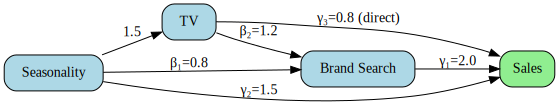

In [6]:
# Create DAG visualization
dag = graphviz.Digraph(comment='Marketing Attribution DAG')
dag.attr(rankdir='LR')
dag.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')

# Nodes
dag.node('S', 'Seasonality')
dag.node('T', 'TV')
dag.node('B', 'Brand Search')
dag.node('Y', 'Sales', fillcolor='lightgreen')

# Edges with labels
dag.edge('S', 'T', label='1.5')
dag.edge('S', 'B', label='β₁=0.8')
dag.edge('S', 'Y', label='γ₂=1.5')
dag.edge('T', 'B', label='β₂=1.2')
dag.edge('T', 'Y', label='γ₃=0.8 (direct)')
dag.edge('B', 'Y', label='γ₁=2.0')

# Display
dag

### Correlation Structure

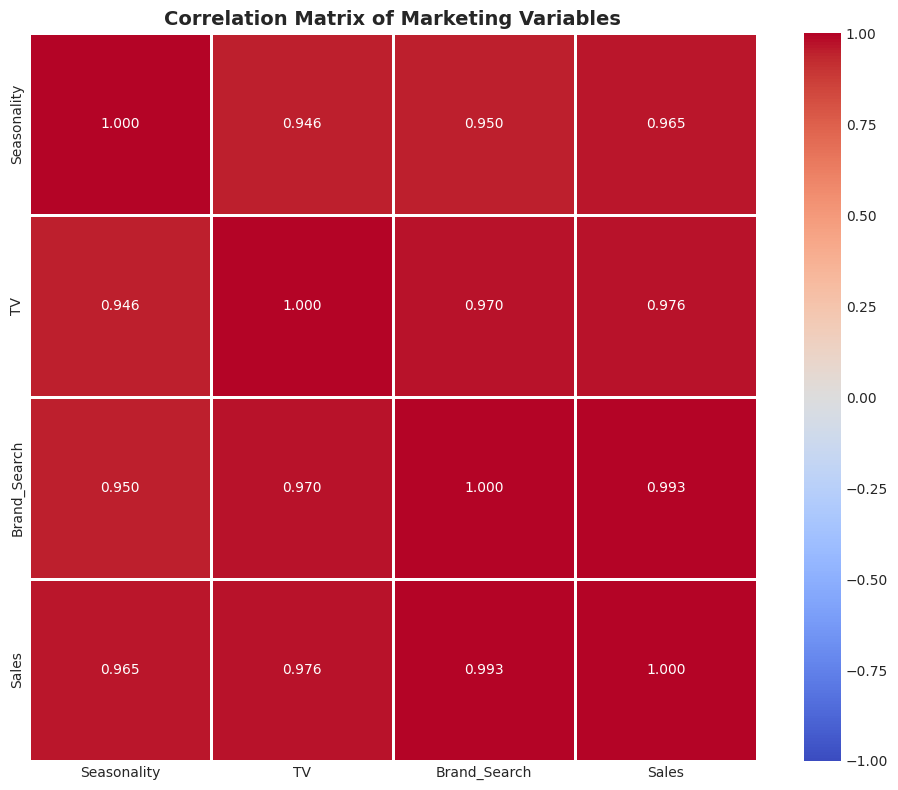


Note: High correlation between TV and Brand Search reflects causal relationship.
High correlation between variables and Sales reflects both direct and indirect effects.


In [7]:
# Correlation matrix
corr_matrix = df.corr()

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax, 
            square=True, linewidths=1)
ax.set_title('Correlation Matrix of Marketing Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNote: High correlation between TV and Brand Search reflects causal relationship.")
print("High correlation between variables and Sales reflects both direct and indirect effects.")

### Pairwise Relationships

<Figure size 1400x1000 with 0 Axes>

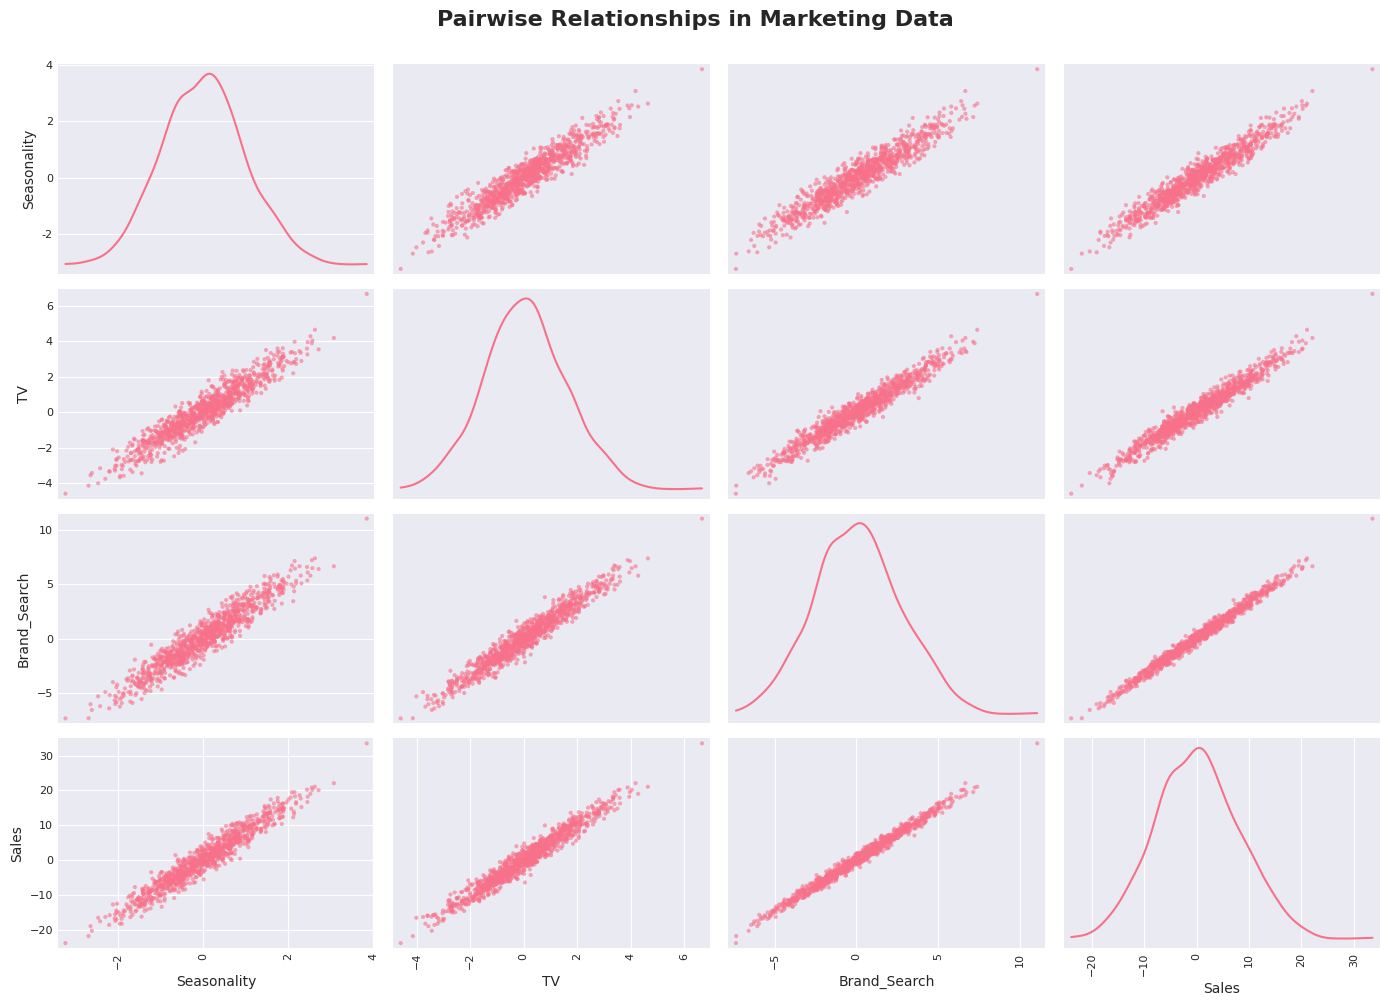

In [8]:
# Scatter plot matrix
fig = plt.figure(figsize=(14, 10))
pd.plotting.scatter_matrix(df, figsize=(14, 10), alpha=0.6, diagonal='kde')
plt.suptitle('Pairwise Relationships in Marketing Data', y=1.001, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Section 2: Classical OLS Approach

We'll estimate the mediation model using two sequential OLS regressions:

**Model 1 (Mediator Model)**: Brand_Search ~ Seasonality + TV

**Model 2 (Outcome Model)**: Sales ~ Brand_Search + Seasonality + TV

### Key Quantities:
- **Direct Effect of TV on Sales**: γ3 (coefficient in Model 2)
- **Indirect Effect of TV on Sales**: β2 × γ1 (TV → Brand Search × Brand Search → Sales)
- **Total Effect of TV on Sales**: γ3 + β2 × γ1

In [9]:
# Model 1: Brand Search ~ Seasonality + TV
model1_formula = 'Brand_Search ~ Seasonality + TV'
model1 = smf.ols(model1_formula, data=df).fit()

print("="*70)
print("MODEL 1: Brand Search ~ Seasonality + TV (Mediator Model)")
print("="*70)
print(model1.summary())

MODEL 1: Brand Search ~ Seasonality + TV (Mediator Model)
                            OLS Regression Results                            
Dep. Variable:           Brand_Search   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     9707.
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        06:13:22   Log-Likelihood:                -890.63
No. Observations:                1000   AIC:                             1787.
Df Residuals:                     997   BIC:                             1802.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [10]:
# Model 2: Sales ~ Brand_Search + Seasonality + TV
model2_formula = 'Sales ~ Brand_Search + Seasonality + TV'
model2 = smf.ols(model2_formula, data=df).fit()

print("="*70)
print("MODEL 2: Sales ~ Brand_Search + Seasonality + TV (Outcome Model)")
print("="*70)
print(model2.summary())

MODEL 2: Sales ~ Brand_Search + Seasonality + TV (Outcome Model)
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 4.055e+04
Date:                Fri, 13 Feb 2026   Prob (F-statistic):               0.00
Time:                        06:13:22   Log-Likelihood:                -1086.7
No. Observations:                1000   AIC:                             2181.
Df Residuals:                     996   BIC:                             2201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

### Extract Direct Effects

In [11]:
# Extract coefficients and confidence intervals from Model 1
beta1_seasonality = model1.params['Seasonality']
beta1_seasonality_se = model1.bse['Seasonality']
beta1_seasonality_ci = model1.conf_int().loc['Seasonality'].values

beta2_tv = model1.params['TV']
beta2_tv_se = model1.bse['TV']
beta2_tv_ci = model1.conf_int().loc['TV'].values

# Extract coefficients and confidence intervals from Model 2
gamma1_bs = model2.params['Brand_Search']
gamma1_bs_se = model2.bse['Brand_Search']
gamma1_bs_ci = model2.conf_int().loc['Brand_Search'].values

gamma2_seasonality = model2.params['Seasonality']
gamma2_seasonality_se = model2.bse['Seasonality']
gamma2_seasonality_ci = model2.conf_int().loc['Seasonality'].values

gamma3_tv = model2.params['TV']
gamma3_tv_se = model2.bse['TV']
gamma3_tv_ci = model2.conf_int().loc['TV'].values

print("Direct Effects from OLS:")
print(f"\nβ1 (Seasonality → Brand Search): {beta1_seasonality:.4f} (SE: {beta1_seasonality_se:.4f})")
print(f"   95% CI: [{beta1_seasonality_ci[0]:.4f}, {beta1_seasonality_ci[1]:.4f}]")
print(f"   True value: {true_params['bs_seasonality']:.4f}")

print(f"\nβ2 (TV → Brand Search): {beta2_tv:.4f} (SE: {beta2_tv_se:.4f})")
print(f"   95% CI: [{beta2_tv_ci[0]:.4f}, {beta2_tv_ci[1]:.4f}]")
print(f"   True value: {true_params['bs_tv']:.4f}")

print(f"\nγ1 (Brand Search → Sales, direct): {gamma1_bs:.4f} (SE: {gamma1_bs_se:.4f})")
print(f"   95% CI: [{gamma1_bs_ci[0]:.4f}, {gamma1_bs_ci[1]:.4f}]")
print(f"   True value: {true_params['sales_brand_search']:.4f}")

print(f"\nγ2 (Seasonality → Sales): {gamma2_seasonality:.4f} (SE: {gamma2_seasonality_se:.4f})")
print(f"   95% CI: [{gamma2_seasonality_ci[0]:.4f}, {gamma2_seasonality_ci[1]:.4f}]")
print(f"   True value: {true_params['sales_seasonality']:.4f}")

print(f"\nγ3 (TV → Sales, direct): {gamma3_tv:.4f} (SE: {gamma3_tv_se:.4f})")
print(f"   95% CI: [{gamma3_tv_ci[0]:.4f}, {gamma3_tv_ci[1]:.4f}]")
print(f"   True value: {true_params['sales_tv']:.4f}")

Direct Effects from OLS:

β1 (Seasonality → Brand Search): 0.8314 (SE: 0.0587)
   95% CI: [0.7163, 0.9465]
   True value: 0.8000

β2 (TV → Brand Search): 1.1878 (SE: 0.0375)
   95% CI: [1.1142, 1.2614]
   True value: 1.2000

γ1 (Brand Search → Sales, direct): 2.0260 (SE: 0.0385)
   95% CI: [1.9503, 2.1016]
   True value: 2.0000

γ2 (Seasonality → Sales): 1.5866 (SE: 0.0783)
   95% CI: [1.4330, 1.7402]
   True value: 1.5000

γ3 (TV → Sales, direct): 0.6894 (SE: 0.0646)
   95% CI: [0.5625, 0.8162]
   True value: 0.8000


### Calculate Total Effects with Delta Method

In [12]:
# TV Total Effect = Direct + Indirect = γ3 + β2 × γ1
tv_direct_effect = gamma3_tv
tv_indirect_effect = beta2_tv * gamma1_bs
tv_total_effect = tv_direct_effect + tv_indirect_effect

# Delta method for standard error of total effect
# Var(β2 × γ1 + γ3) ≈ γ1² Var(β2) + β2² Var(γ1) + Var(γ3) + 2γ1β2 Cov(β2, γ1)
# Since β2 and γ1 come from different models, Cov(β2, γ1) ≈ 0
tv_total_se = np.sqrt(
    (gamma1_bs**2 * beta2_tv_se**2) +  # Var term from β2
    (beta2_tv**2 * gamma1_bs_se**2) +   # Var term from γ1
    (gamma3_tv_se**2)                   # Var term from γ3
)

# 95% CI for total effect
tv_total_ci_lower = tv_total_effect - 1.96 * tv_total_se
tv_total_ci_upper = tv_total_effect + 1.96 * tv_total_se

print("TV Effects Decomposition (OLS):")
print(f"\nDirect Effect (γ3): {tv_direct_effect:.4f}")
print(f"Indirect Effect (β2 × γ1): {tv_indirect_effect:.4f}")
print(f"Total Effect: {tv_total_effect:.4f} (SE: {tv_total_se:.4f})")
print(f"95% CI for Total Effect: [{tv_total_ci_lower:.4f}, {tv_total_ci_upper:.4f}]")
print(f"\nTrue Total Effect: {true_params['tv_total_effect']:.4f}")
print(f"\nProportion Mediated: {tv_indirect_effect/tv_total_effect:.1%}")

TV Effects Decomposition (OLS):

Direct Effect (γ3): 0.6894
Indirect Effect (β2 × γ1): 2.4064
Total Effect: 3.0958 (SE: 0.1097)
95% CI for Total Effect: [2.8807, 3.3109]

True Total Effect: 3.2000

Proportion Mediated: 77.7%


In [13]:
# Brand Search Total Effect (no mediation through it)
bs_total_effect = gamma1_bs
bs_total_se = gamma1_bs_se
bs_total_ci = gamma1_bs_ci

print("Brand Search Effects (OLS):")
print(f"\nTotal Effect (= Direct Effect): {bs_total_effect:.4f} (SE: {bs_total_se:.4f})")
print(f"95% CI: [{bs_total_ci[0]:.4f}, {bs_total_ci[1]:.4f}]")
print(f"True Total Effect: {true_params['bs_total_effect']:.4f}")

Brand Search Effects (OLS):

Total Effect (= Direct Effect): 2.0260 (SE: 0.0385)
95% CI: [1.9503, 2.1016]
True Total Effect: 2.0000


### OLS Results Summary Table

In [14]:
# Create comprehensive OLS results table
ols_results = pd.DataFrame({
    'Parameter': [
        'β1 (Seasonality → Brand Search)',
        'β2 (TV → Brand Search)',
        'γ1 (Brand Search → Sales)',
        'γ2 (Seasonality → Sales)',
        'γ3 (TV → Sales, direct)',
        'σ1 (Brand Search model)',
        'σ2 (Sales model)',
        'TV Indirect Effect',
        'TV Total Effect',
        'Brand Search Total Effect'
    ],
    'True Value': [
        true_params['bs_seasonality'],
        true_params['bs_tv'],
        true_params['sales_brand_search'],
        true_params['sales_seasonality'],
        true_params['sales_tv'],
        true_params['bs_sigma'],
        true_params['sales_sigma'],
        true_params['bs_tv'] * true_params['sales_brand_search'],
        true_params['tv_total_effect'],
        true_params['bs_total_effect']
    ],
    'OLS Estimate': [
        beta1_seasonality,
        beta2_tv,
        gamma1_bs,
        gamma2_seasonality,
        gamma3_tv,
        np.sqrt(model1.scale),
        np.sqrt(model2.scale),
        tv_indirect_effect,
        tv_total_effect,
        bs_total_effect
    ],
    'Std Error': [
        beta1_seasonality_se,
        beta2_tv_se,
        gamma1_bs_se,
        gamma2_seasonality_se,
        gamma3_tv_se,
        np.nan,  # SE for sigma not directly available
        np.nan,
        np.sqrt((gamma1_bs**2 * beta2_tv_se**2) + (beta2_tv**2 * gamma1_bs_se**2)),
        tv_total_se,
        bs_total_se
    ],
    '95% CI Lower': [
        beta1_seasonality_ci[0],
        beta2_tv_ci[0],
        gamma1_bs_ci[0],
        gamma2_seasonality_ci[0],
        gamma3_tv_ci[0],
        np.nan,
        np.nan,
        tv_indirect_effect - 1.96 * np.sqrt((gamma1_bs**2 * beta2_tv_se**2) + (beta2_tv**2 * gamma1_bs_se**2)),
        tv_total_ci_lower,
        bs_total_ci[0]
    ],
    '95% CI Upper': [
        beta1_seasonality_ci[1],
        beta2_tv_ci[1],
        gamma1_bs_ci[1],
        gamma2_seasonality_ci[1],
        gamma3_tv_ci[1],
        np.nan,
        np.nan,
        tv_indirect_effect + 1.96 * np.sqrt((gamma1_bs**2 * beta2_tv_se**2) + (beta2_tv**2 * gamma1_bs_se**2)),
        tv_total_ci_upper,
        bs_total_ci[1]
    ]
})

# Calculate errors
ols_results['Absolute Error'] = np.abs(ols_results['OLS Estimate'] - ols_results['True Value'])
ols_results['Relative Error (%)'] = 100 * ols_results['Absolute Error'] / np.abs(ols_results['True Value'])

print("\n" + "="*100)
print("OLS ESTIMATION RESULTS")
print("="*100)
print(ols_results.to_string(index=False))
print("\n" + "="*100)


OLS ESTIMATION RESULTS
                      Parameter  True Value  OLS Estimate  Std Error  95% CI Lower  95% CI Upper  Absolute Error  Relative Error (%)
β1 (Seasonality → Brand Search)         0.8      0.831403   0.058654      0.716304      0.946502        0.031403            3.925339
         β2 (TV → Brand Search)         1.2      1.187787   0.037490      1.114218      1.261356        0.012213            1.017734
      γ1 (Brand Search → Sales)         2.0      2.025982   0.038549      1.950335      2.101630        0.025982            1.299117
       γ2 (Seasonality → Sales)         1.5      1.586618   0.078258      1.433049      1.740187        0.086618            5.774536
        γ3 (TV → Sales, direct)         0.8      0.689377   0.064645      0.562521      0.816233        0.110623           13.827860
        σ1 (Brand Search model)         0.6      0.590488        NaN           NaN           NaN        0.009512            1.585324
               σ2 (Sales model)         0.7  

---
## Section 3: Bayesian Approach (PyMC)

We'll estimate both equations simultaneously in a single Bayesian model, allowing for joint inference and proper uncertainty quantification of derived quantities.

In [15]:
# Prepare data
seasonality_data = df['Seasonality'].values
tv_data = df['TV'].values
brand_search_data = df['Brand_Search'].values
sales_data = df['Sales'].values

print("Data prepared for Bayesian modeling")
print(f"n = {len(df)} observations")

Data prepared for Bayesian modeling
n = 1000 observations


In [16]:
# Define Bayesian model
with pm.Model() as marketing_model:
    # Priors for Brand Search equation
    alpha1 = pm.Normal('alpha1', mu=0, sigma=5)
    beta1 = pm.Normal('beta1', mu=0, sigma=3)  # Seasonality → Brand Search
    beta2 = pm.Normal('beta2', mu=0, sigma=3)  # TV → Brand Search
    sigma1 = pm.HalfNormal('sigma1', sigma=2)
    
    # Priors for Sales equation
    alpha2 = pm.Normal('alpha2', mu=0, sigma=5)
    gamma1 = pm.Normal('gamma1', mu=0, sigma=3)  # Brand Search → Sales (direct)
    gamma2 = pm.Normal('gamma2', mu=0, sigma=3)  # Seasonality → Sales
    gamma3 = pm.Normal('gamma3', mu=0, sigma=3)  # TV → Sales (direct)
    sigma2 = pm.HalfNormal('sigma2', sigma=2)
    
    # Likelihood for Brand Search
    mu_bs = alpha1 + beta1 * seasonality_data + beta2 * tv_data
    bs_obs = pm.Normal('bs_obs', mu=mu_bs, sigma=sigma1, observed=brand_search_data)
    
    # Likelihood for Sales
    mu_sales = alpha2 + gamma1 * brand_search_data + gamma2 * seasonality_data + gamma3 * tv_data
    sales_obs = pm.Normal('sales_obs', mu=mu_sales, sigma=sigma2, observed=sales_data)
    
    # Derived quantities: Total effects
    tv_indirect = pm.Deterministic('tv_indirect', beta2 * gamma1)
    tv_total = pm.Deterministic('tv_total', gamma3 + beta2 * gamma1)
    bs_total = pm.Deterministic('bs_total', gamma1)  # Same as direct effect
    
    # Proportion mediated
    prop_mediated = pm.Deterministic('prop_mediated', (beta2 * gamma1) / (gamma3 + beta2 * gamma1))

print("Bayesian model defined")
print(marketing_model)

Bayesian model defined


In [17]:
# Sample from posterior
with marketing_model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        random_seed=42,
        return_inferencedata=True,
        target_accept=0.95
    )

print("\nSampling complete!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, beta1, beta2, sigma1, alpha2, gamma1, gamma2, gamma3, sigma2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.



Sampling complete!


### Check Convergence Diagnostics

In [ ]:
# Compute convergence diagnostics
summary = az.summary(trace, var_names=['beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3', 
                                        'sigma1', 'sigma2', 'tv_indirect', 'tv_total', 
                                        'bs_total', 'prop_mediated'])

print("\nConvergence Diagnostics:")
print("="*80)

# Dynamically get HDI column names (ArviZ versions may differ)
hdi_cols = [col for col in summary.columns if 'hdi' in col.lower()]
display_cols = ['mean', 'sd'] + hdi_cols + ['r_hat', 'ess_bulk', 'ess_tail']
display_cols = [col for col in display_cols if col in summary.columns]

print(summary[display_cols])
print("\n" + "="*80)

# Check for convergence issues
rhat_issues = summary[summary['r_hat'] > 1.01]
if len(rhat_issues) > 0:
    print("\n⚠️  WARNING: Some parameters have R-hat > 1.01:")
    print(rhat_issues[['r_hat']])
else:
    print("\n✓ All R-hat values < 1.01: Chains converged successfully")

ess_issues = summary[(summary['ess_bulk'] < 400) | (summary['ess_tail'] < 400)]
if len(ess_issues) > 0:
    print("\n⚠️  WARNING: Some parameters have low ESS:")
    print(ess_issues[['ess_bulk', 'ess_tail']])
else:
    print("✓ All ESS values > 400: Good effective sample size")


Convergence Diagnostics:
                mean     sd  hdi_3%  hdi_97%  r_hat  ess_bulk  ess_tail
beta1          0.831  0.059   0.714    0.935    1.0    4973.0    5715.0
beta2          1.188  0.038   1.116    1.258    1.0    5019.0    5905.0
gamma1         2.026  0.039   1.952    2.100    1.0    5862.0    6283.0
gamma2         1.585  0.078   1.435    1.727    1.0    8289.0    5602.0
gamma3         0.690  0.065   0.573    0.820    1.0    5825.0    5135.0
sigma1         0.591  0.013   0.567    0.617    1.0    9823.0    5005.0
sigma2         0.720  0.016   0.689    0.750    1.0    9151.0    5731.0
tv_indirect    2.407  0.089   2.238    2.574    1.0    5328.0    5701.0
tv_total       3.096  0.089   2.930    3.265    1.0    5416.0    5835.0
bs_total       2.026  0.039   1.952    2.100    1.0    5862.0    6283.0
prop_mediated  0.777  0.020   0.740    0.814    1.0    5691.0    5458.0


✓ All R-hat values < 1.01: Chains converged successfully
✓ All ESS values > 400: Good effective sample size


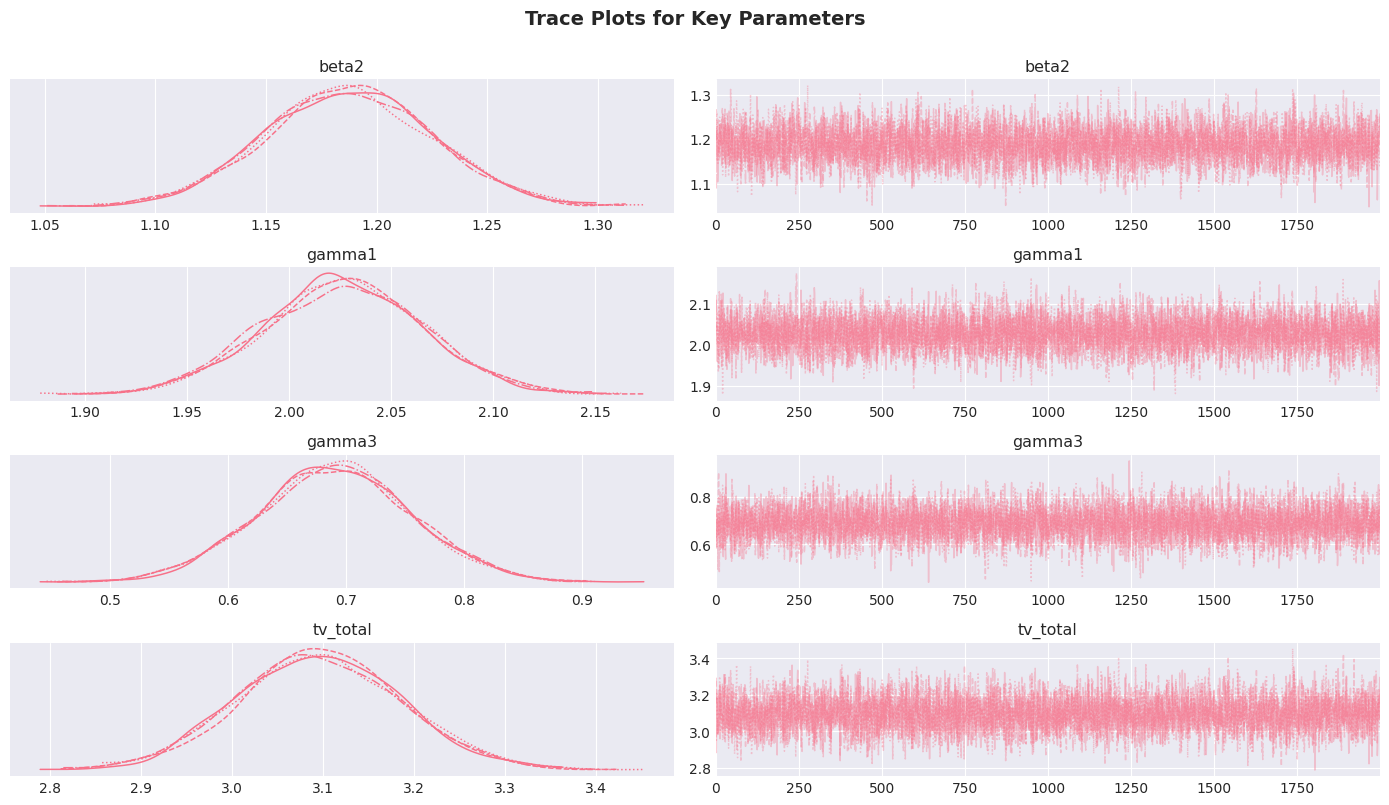

In [19]:
# Trace plots for key parameters
az.plot_trace(
    trace, 
    var_names=['beta2', 'gamma1', 'gamma3', 'tv_total'],
    compact=True,
    figsize=(14, 8)
)
plt.suptitle('Trace Plots for Key Parameters', y=1.001, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Posterior Distributions with Ground Truth

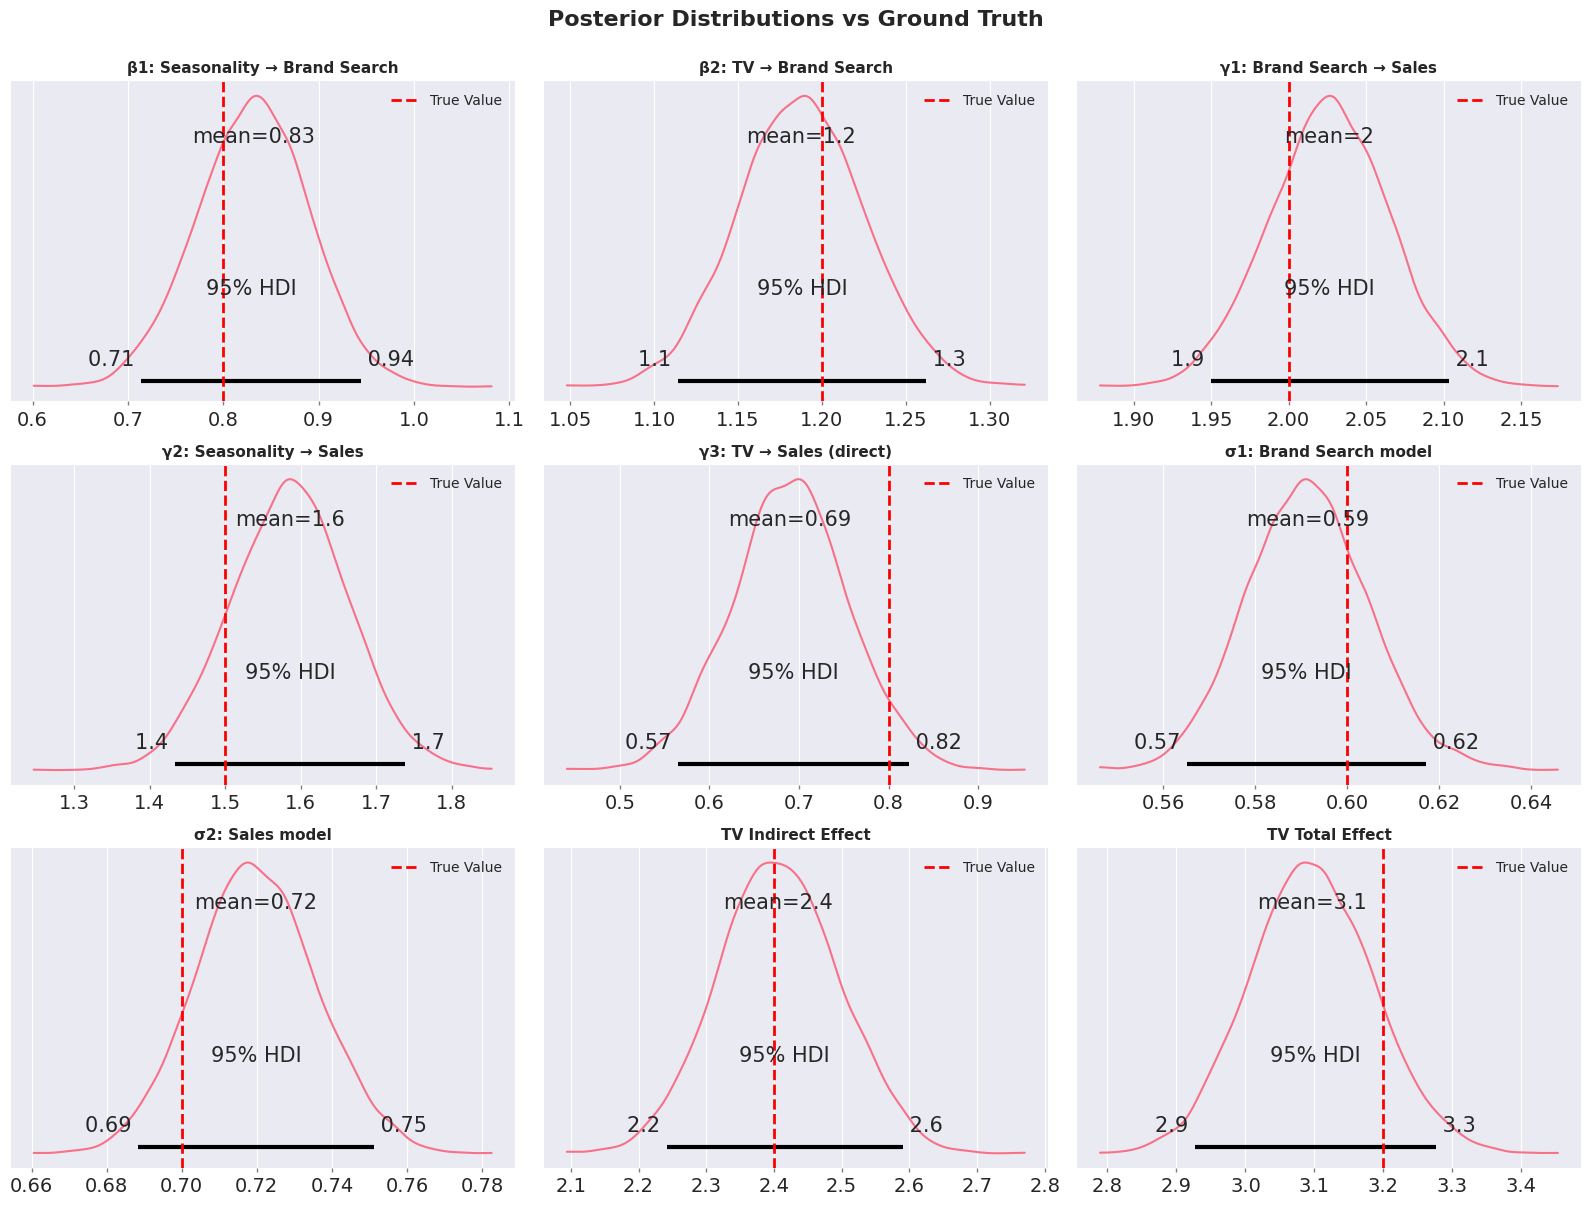

In [20]:
# Plot posterior distributions with ground truth overlaid
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

params_to_plot = [
    ('beta1', 'bs_seasonality', 'β1: Seasonality → Brand Search'),
    ('beta2', 'bs_tv', 'β2: TV → Brand Search'),
    ('gamma1', 'sales_brand_search', 'γ1: Brand Search → Sales'),
    ('gamma2', 'sales_seasonality', 'γ2: Seasonality → Sales'),
    ('gamma3', 'sales_tv', 'γ3: TV → Sales (direct)'),
    ('sigma1', 'bs_sigma', 'σ1: Brand Search model'),
    ('sigma2', 'sales_sigma', 'σ2: Sales model'),
    ('tv_indirect', None, 'TV Indirect Effect'),
    ('tv_total', 'tv_total_effect', 'TV Total Effect'),
]

for idx, (param_name, true_param_key, label) in enumerate(params_to_plot):
    ax = axes[idx]
    
    # Plot posterior
    az.plot_posterior(
        trace, 
        var_names=[param_name],
        ax=ax,
        hdi_prob=0.95,
        point_estimate='mean'
    )
    
    # Add ground truth line
    if true_param_key is not None:
        true_value = true_params[true_param_key]
    elif param_name == 'tv_indirect':
        true_value = true_params['bs_tv'] * true_params['sales_brand_search']
    
    if true_param_key is not None or param_name == 'tv_indirect':
        ax.axvline(true_value, color='red', linestyle='--', linewidth=2, label='True Value')
        ax.legend()
    
    ax.set_title(label, fontsize=11, fontweight='bold')

plt.suptitle('Posterior Distributions vs Ground Truth', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

### Extract Posterior Summaries

In [22]:
# Extract posterior means and HDIs
posterior_summary = az.summary(
    trace, 
    var_names=['beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3', 
               'sigma1', 'sigma2', 'tv_indirect', 'tv_total', 'bs_total', 'prop_mediated'],
    hdi_prob=0.95
)

print("\n" + "="*100)
print("POSTERIOR SUMMARY STATISTICS")
print("="*100)

# Display all available columns (in case column names vary by ArviZ version)
print(posterior_summary)
print("\n" + "="*100)


POSTERIOR SUMMARY STATISTICS
                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta1          0.831  0.059     0.714      0.945      0.001    0.001   
beta2          1.188  0.038     1.114      1.262      0.001    0.000   
gamma1         2.026  0.039     1.950      2.103      0.001    0.000   
gamma2         1.585  0.078     1.434      1.738      0.001    0.001   
gamma3         0.690  0.065     0.565      0.823      0.001    0.001   
sigma1         0.591  0.013     0.565      0.617      0.000    0.000   
sigma2         0.720  0.016     0.688      0.751      0.000    0.000   
tv_indirect    2.407  0.089     2.242      2.590      0.001    0.001   
tv_total       3.096  0.089     2.927      3.276      0.001    0.001   
bs_total       2.026  0.039     1.950      2.103      0.001    0.000   
prop_mediated  0.777  0.020     0.738      0.815      0.000    0.000   

               ess_bulk  ess_tail  r_hat  
beta1            4973.0    5715.0    1.0  
beta2            50

### Bayesian Results Table

In [23]:
# Create comprehensive Bayesian results table

# Dynamically get HDI column names (ArviZ versions may differ)
hdi_cols = sorted([col for col in posterior_summary.columns if 'hdi' in col.lower()])
if len(hdi_cols) >= 2:
    hdi_lower_col = hdi_cols[0]  # Usually hdi_3% or hdi_2.5%
    hdi_upper_col = hdi_cols[-1]  # Usually hdi_97% or hdi_97.5%
else:
    # Fallback: try common names
    for lower_name in ['hdi_3%', 'hdi_2.5%', 'hdi_5%']:
        if lower_name in posterior_summary.columns:
            hdi_lower_col = lower_name
            break
    for upper_name in ['hdi_97%', 'hdi_97.5%', 'hdi_95%']:
        if upper_name in posterior_summary.columns:
            hdi_upper_col = upper_name
            break

print(f"Using HDI columns: {hdi_lower_col}, {hdi_upper_col}")

bayesian_results = pd.DataFrame({
    'Parameter': [
        'β1 (Seasonality → Brand Search)',
        'β2 (TV → Brand Search)',
        'γ1 (Brand Search → Sales)',
        'γ2 (Seasonality → Sales)',
        'γ3 (TV → Sales, direct)',
        'σ1 (Brand Search model)',
        'σ2 (Sales model)',
        'TV Indirect Effect',
        'TV Total Effect',
        'Brand Search Total Effect',
        'Proportion Mediated'
    ],
    'True Value': [
        true_params['bs_seasonality'],
        true_params['bs_tv'],
        true_params['sales_brand_search'],
        true_params['sales_seasonality'],
        true_params['sales_tv'],
        true_params['bs_sigma'],
        true_params['sales_sigma'],
        true_params['bs_tv'] * true_params['sales_brand_search'],
        true_params['tv_total_effect'],
        true_params['bs_total_effect'],
        (true_params['bs_tv'] * true_params['sales_brand_search']) / true_params['tv_total_effect']
    ],
    'Posterior Mean': [
        posterior_summary.loc['beta1', 'mean'],
        posterior_summary.loc['beta2', 'mean'],
        posterior_summary.loc['gamma1', 'mean'],
        posterior_summary.loc['gamma2', 'mean'],
        posterior_summary.loc['gamma3', 'mean'],
        posterior_summary.loc['sigma1', 'mean'],
        posterior_summary.loc['sigma2', 'mean'],
        posterior_summary.loc['tv_indirect', 'mean'],
        posterior_summary.loc['tv_total', 'mean'],
        posterior_summary.loc['bs_total', 'mean'],
        posterior_summary.loc['prop_mediated', 'mean']
    ],
    'Posterior SD': [
        posterior_summary.loc['beta1', 'sd'],
        posterior_summary.loc['beta2', 'sd'],
        posterior_summary.loc['gamma1', 'sd'],
        posterior_summary.loc['gamma2', 'sd'],
        posterior_summary.loc['gamma3', 'sd'],
        posterior_summary.loc['sigma1', 'sd'],
        posterior_summary.loc['sigma2', 'sd'],
        posterior_summary.loc['tv_indirect', 'sd'],
        posterior_summary.loc['tv_total', 'sd'],
        posterior_summary.loc['bs_total', 'sd'],
        posterior_summary.loc['prop_mediated', 'sd']
    ],
    '95% HDI Lower': [
        posterior_summary.loc['beta1', hdi_lower_col],
        posterior_summary.loc['beta2', hdi_lower_col],
        posterior_summary.loc['gamma1', hdi_lower_col],
        posterior_summary.loc['gamma2', hdi_lower_col],
        posterior_summary.loc['gamma3', hdi_lower_col],
        posterior_summary.loc['sigma1', hdi_lower_col],
        posterior_summary.loc['sigma2', hdi_lower_col],
        posterior_summary.loc['tv_indirect', hdi_lower_col],
        posterior_summary.loc['tv_total', hdi_lower_col],
        posterior_summary.loc['bs_total', hdi_lower_col],
        posterior_summary.loc['prop_mediated', hdi_lower_col]
    ],
    '95% HDI Upper': [
        posterior_summary.loc['beta1', hdi_upper_col],
        posterior_summary.loc['beta2', hdi_upper_col],
        posterior_summary.loc['gamma1', hdi_upper_col],
        posterior_summary.loc['gamma2', hdi_upper_col],
        posterior_summary.loc['gamma3', hdi_upper_col],
        posterior_summary.loc['sigma1', hdi_upper_col],
        posterior_summary.loc['sigma2', hdi_upper_col],
        posterior_summary.loc['tv_indirect', hdi_upper_col],
        posterior_summary.loc['tv_total', hdi_upper_col],
        posterior_summary.loc['bs_total', hdi_upper_col],
        posterior_summary.loc['prop_mediated', hdi_upper_col]
    ]
})

# Calculate errors
bayesian_results['Absolute Error'] = np.abs(bayesian_results['Posterior Mean'] - bayesian_results['True Value'])
bayesian_results['Relative Error (%)'] = 100 * bayesian_results['Absolute Error'] / np.abs(bayesian_results['True Value'])

print("\n" + "="*100)
print("BAYESIAN ESTIMATION RESULTS")
print("="*100)
print(bayesian_results.to_string(index=False))
print("\n" + "="*100)

Using HDI columns: hdi_2.5%, hdi_97.5%

BAYESIAN ESTIMATION RESULTS
                      Parameter  True Value  Posterior Mean  Posterior SD  95% HDI Lower  95% HDI Upper  Absolute Error  Relative Error (%)
β1 (Seasonality → Brand Search)        0.80           0.831         0.059          0.714          0.945           0.031            3.875000
         β2 (TV → Brand Search)        1.20           1.188         0.038          1.114          1.262           0.012            1.000000
      γ1 (Brand Search → Sales)        2.00           2.026         0.039          1.950          2.103           0.026            1.300000
       γ2 (Seasonality → Sales)        1.50           1.585         0.078          1.434          1.738           0.085            5.666667
        γ3 (TV → Sales, direct)        0.80           0.690         0.065          0.565          0.823           0.110           13.750000
        σ1 (Brand Search model)        0.60           0.591         0.013          0.565    

---
## Section 4: Comprehensive Comparison

Let's compare OLS and Bayesian approaches side-by-side.

### Side-by-Side Comparison Table

In [24]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Parameter': [
        'β1 (Seasonality → Brand Search)',
        'β2 (TV → Brand Search)',
        'γ1 (Brand Search → Sales)',
        'γ2 (Seasonality → Sales)',
        'γ3 (TV → Sales, direct)',
        'σ1 (Brand Search model)',
        'σ2 (Sales model)',
        'TV Indirect Effect',
        'TV Total Effect',
        'Brand Search Total Effect'
    ],
    'Ground Truth': [
        true_params['bs_seasonality'],
        true_params['bs_tv'],
        true_params['sales_brand_search'],
        true_params['sales_seasonality'],
        true_params['sales_tv'],
        true_params['bs_sigma'],
        true_params['sales_sigma'],
        true_params['bs_tv'] * true_params['sales_brand_search'],
        true_params['tv_total_effect'],
        true_params['bs_total_effect']
    ],
    'OLS Estimate': [
        beta1_seasonality,
        beta2_tv,
        gamma1_bs,
        gamma2_seasonality,
        gamma3_tv,
        np.sqrt(model1.scale),
        np.sqrt(model2.scale),
        tv_indirect_effect,
        tv_total_effect,
        bs_total_effect
    ],
    'OLS SE/SD': [
        beta1_seasonality_se,
        beta2_tv_se,
        gamma1_bs_se,
        gamma2_seasonality_se,
        gamma3_tv_se,
        np.nan,
        np.nan,
        np.sqrt((gamma1_bs**2 * beta2_tv_se**2) + (beta2_tv**2 * gamma1_bs_se**2)),
        tv_total_se,
        bs_total_se
    ],
    'Bayesian Mean': [
        posterior_summary.loc['beta1', 'mean'],
        posterior_summary.loc['beta2', 'mean'],
        posterior_summary.loc['gamma1', 'mean'],
        posterior_summary.loc['gamma2', 'mean'],
        posterior_summary.loc['gamma3', 'mean'],
        posterior_summary.loc['sigma1', 'mean'],
        posterior_summary.loc['sigma2', 'mean'],
        posterior_summary.loc['tv_indirect', 'mean'],
        posterior_summary.loc['tv_total', 'mean'],
        posterior_summary.loc['bs_total', 'mean']
    ],
    'Bayesian SD': [
        posterior_summary.loc['beta1', 'sd'],
        posterior_summary.loc['beta2', 'sd'],
        posterior_summary.loc['gamma1', 'sd'],
        posterior_summary.loc['gamma2', 'sd'],
        posterior_summary.loc['gamma3', 'sd'],
        posterior_summary.loc['sigma1', 'sd'],
        posterior_summary.loc['sigma2', 'sd'],
        posterior_summary.loc['tv_indirect', 'sd'],
        posterior_summary.loc['tv_total', 'sd'],
        posterior_summary.loc['bs_total', 'sd']
    ]
})

# Calculate absolute errors
comparison_df['OLS Abs Error'] = np.abs(comparison_df['OLS Estimate'] - comparison_df['Ground Truth'])
comparison_df['Bayesian Abs Error'] = np.abs(comparison_df['Bayesian Mean'] - comparison_df['Ground Truth'])

# Calculate relative errors
comparison_df['OLS Rel Error (%)'] = 100 * comparison_df['OLS Abs Error'] / np.abs(comparison_df['Ground Truth'])
comparison_df['Bayesian Rel Error (%)'] = 100 * comparison_df['Bayesian Abs Error'] / np.abs(comparison_df['Ground Truth'])

print("\n" + "="*120)
print("COMPREHENSIVE COMPARISON: OLS vs BAYESIAN")
print("="*120)
print(comparison_df.to_string(index=False))
print("\n" + "="*120)

# Summary statistics
print("\nSummary of Estimation Performance:")
print(f"OLS Mean Absolute Error: {comparison_df['OLS Abs Error'].mean():.4f}")
print(f"Bayesian Mean Absolute Error: {comparison_df['Bayesian Abs Error'].mean():.4f}")
print(f"\nOLS Mean Relative Error: {comparison_df['OLS Rel Error (%)'].mean():.2f}%")
print(f"Bayesian Mean Relative Error: {comparison_df['Bayesian Rel Error (%)'].mean():.2f}%")


COMPREHENSIVE COMPARISON: OLS vs BAYESIAN
                      Parameter  Ground Truth  OLS Estimate  OLS SE/SD  Bayesian Mean  Bayesian SD  OLS Abs Error  Bayesian Abs Error  OLS Rel Error (%)  Bayesian Rel Error (%)
β1 (Seasonality → Brand Search)           0.8      0.831403   0.058654          0.831        0.059       0.031403               0.031           3.925339                3.875000
         β2 (TV → Brand Search)           1.2      1.187787   0.037490          1.188        0.038       0.012213               0.012           1.017734                1.000000
      γ1 (Brand Search → Sales)           2.0      2.025982   0.038549          2.026        0.039       0.025982               0.026           1.299117                1.300000
       γ2 (Seasonality → Sales)           1.5      1.586618   0.078258          1.585        0.078       0.086618               0.085           5.774536                5.666667
        γ3 (TV → Sales, direct)           0.8      0.689377   0.064645  

### Visualization: Parameter Estimates with Uncertainty

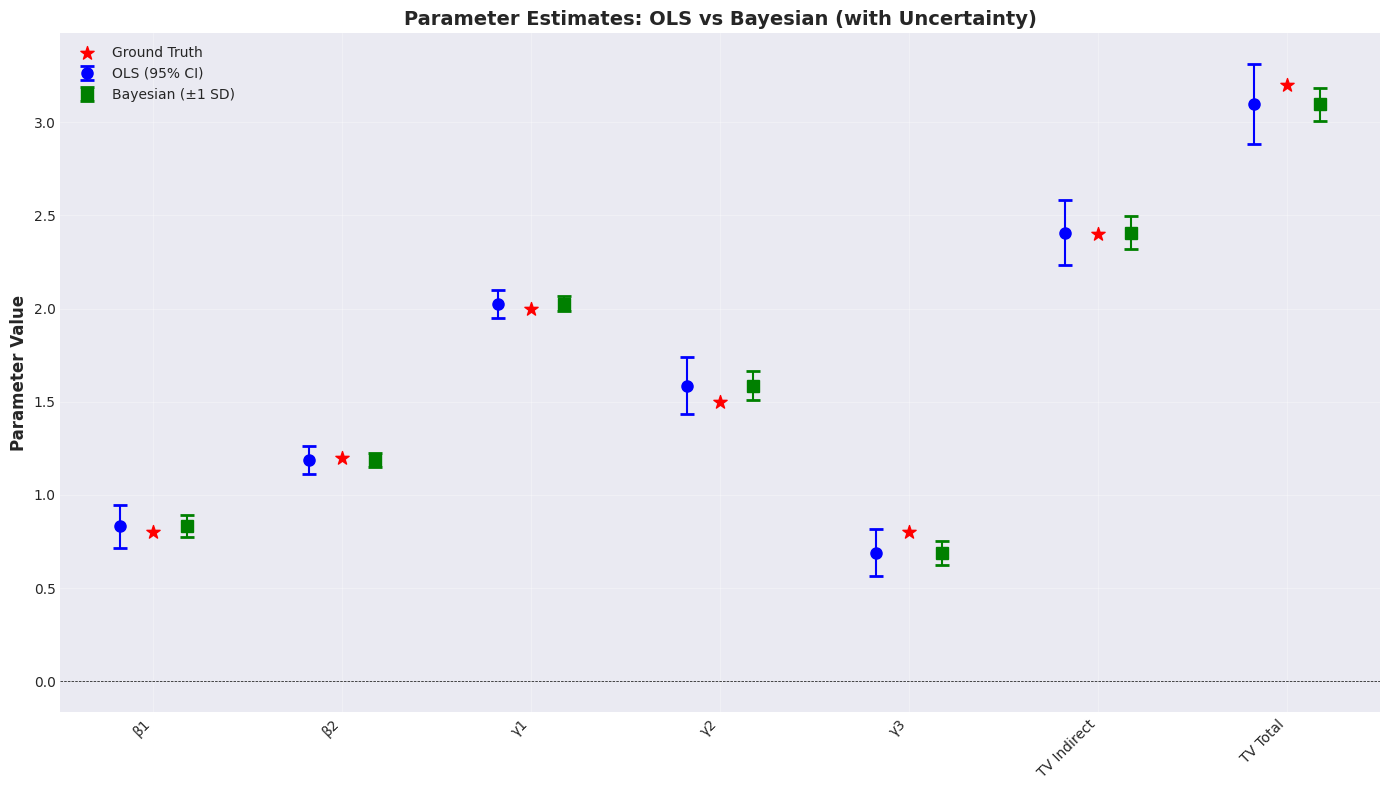

In [25]:
# Plot comparison of estimates with uncertainty
params_to_compare = [
    ('beta1', 'β1', 0),
    ('beta2', 'β2', 1),
    ('gamma1', 'γ1', 2),
    ('gamma2', 'γ2', 3),
    ('gamma3', 'γ3', 4),
    ('tv_indirect', 'TV Indirect', 7),
    ('tv_total', 'TV Total', 8),
]

fig, ax = plt.subplots(figsize=(14, 8))

x_positions = np.arange(len(params_to_compare))
width = 0.35

for idx, (param_name, label, comp_idx) in enumerate(params_to_compare):
    # Ground truth
    true_val = comparison_df.iloc[comp_idx]['Ground Truth']
    
    # OLS
    ols_est = comparison_df.iloc[comp_idx]['OLS Estimate']
    ols_se = comparison_df.iloc[comp_idx]['OLS SE/SD']
    
    # Bayesian
    bay_est = comparison_df.iloc[comp_idx]['Bayesian Mean']
    bay_sd = comparison_df.iloc[comp_idx]['Bayesian SD']
    
    # Plot ground truth
    ax.scatter(idx, true_val, color='red', s=100, marker='*', zorder=5, 
               label='Ground Truth' if idx == 0 else '')
    
    # Plot OLS with error bars (95% CI)
    ax.errorbar(idx - width/2, ols_est, yerr=1.96*ols_se, fmt='o', color='blue', 
                capsize=5, capthick=2, markersize=8, 
                label='OLS (95% CI)' if idx == 0 else '')
    
    # Plot Bayesian with error bars (1 SD)
    ax.errorbar(idx + width/2, bay_est, yerr=bay_sd, fmt='s', color='green', 
                capsize=5, capthick=2, markersize=8,
                label='Bayesian (±1 SD)' if idx == 0 else '')

ax.set_xticks(x_positions)
ax.set_xticklabels([label for _, label, _ in params_to_compare], rotation=45, ha='right')
ax.set_ylabel('Parameter Value', fontsize=12, fontweight='bold')
ax.set_title('Parameter Estimates: OLS vs Bayesian (with Uncertainty)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### Forest Plot Comparison

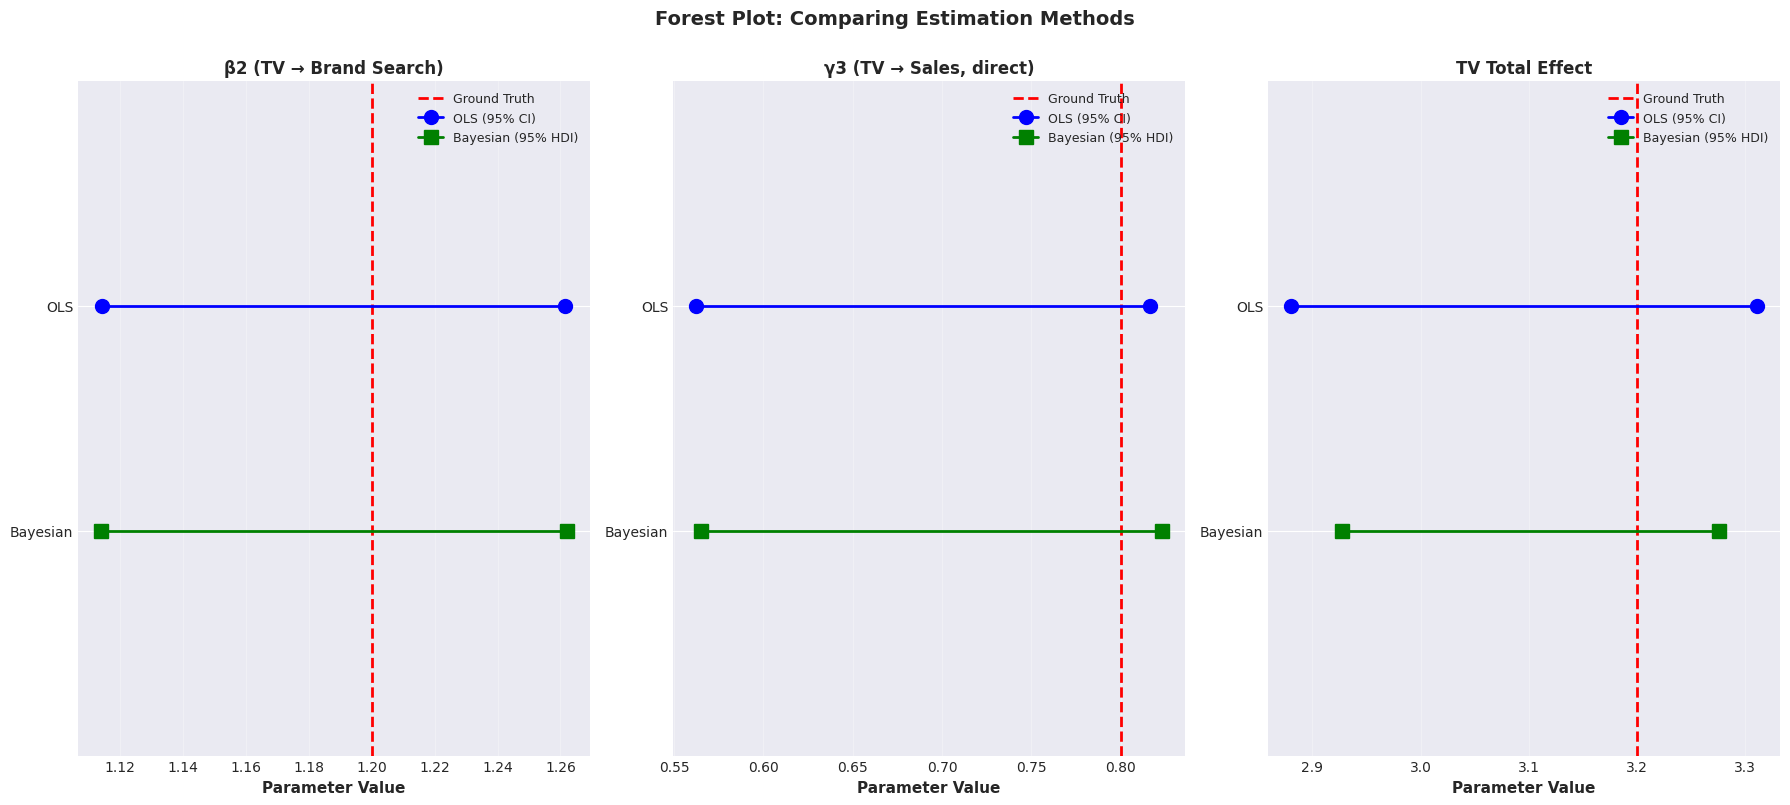

In [26]:
# Create forest plot comparing methods
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Key parameters to highlight
key_params = [
    {
        'name': 'β2 (TV → Brand Search)',
        'true': true_params['bs_tv'],
        'ols': beta2_tv,
        'ols_ci': beta2_tv_ci,
        'bay': posterior_summary.loc['beta2', 'mean'],
        'bay_hdi': [posterior_summary.loc['beta2', hdi_lower_col], 
                    posterior_summary.loc['beta2', hdi_upper_col]]
    },
    {
        'name': 'γ3 (TV → Sales, direct)',
        'true': true_params['sales_tv'],
        'ols': gamma3_tv,
        'ols_ci': gamma3_tv_ci,
        'bay': posterior_summary.loc['gamma3', 'mean'],
        'bay_hdi': [posterior_summary.loc['gamma3', hdi_lower_col], 
                    posterior_summary.loc['gamma3', hdi_upper_col]]
    },
    {
        'name': 'TV Total Effect',
        'true': true_params['tv_total_effect'],
        'ols': tv_total_effect,
        'ols_ci': [tv_total_ci_lower, tv_total_ci_upper],
        'bay': posterior_summary.loc['tv_total', 'mean'],
        'bay_hdi': [posterior_summary.loc['tv_total', hdi_lower_col], 
                    posterior_summary.loc['tv_total', hdi_upper_col]]
    }
]

for idx, param in enumerate(key_params):
    ax = axes[idx]
    
    # Ground truth
    ax.axvline(param['true'], color='red', linestyle='--', linewidth=2, 
               label='Ground Truth', zorder=1)
    
    # OLS
    ax.plot([param['ols_ci'][0], param['ols_ci'][1]], [1, 1], 'bo-', 
            linewidth=2, markersize=10, label='OLS (95% CI)')
    
    # Bayesian
    ax.plot([param['bay_hdi'][0], param['bay_hdi'][1]], [0.5, 0.5], 'gs-', 
            linewidth=2, markersize=10, label='Bayesian (95% HDI)')
    
    ax.set_ylim(0, 1.5)
    ax.set_yticks([0.5, 1])
    ax.set_yticklabels(['Bayesian', 'OLS'])
    ax.set_xlabel('Parameter Value', fontsize=11, fontweight='bold')
    ax.set_title(param['name'], fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Forest Plot: Comparing Estimation Methods', 
             fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

### Mediation Analysis Summary

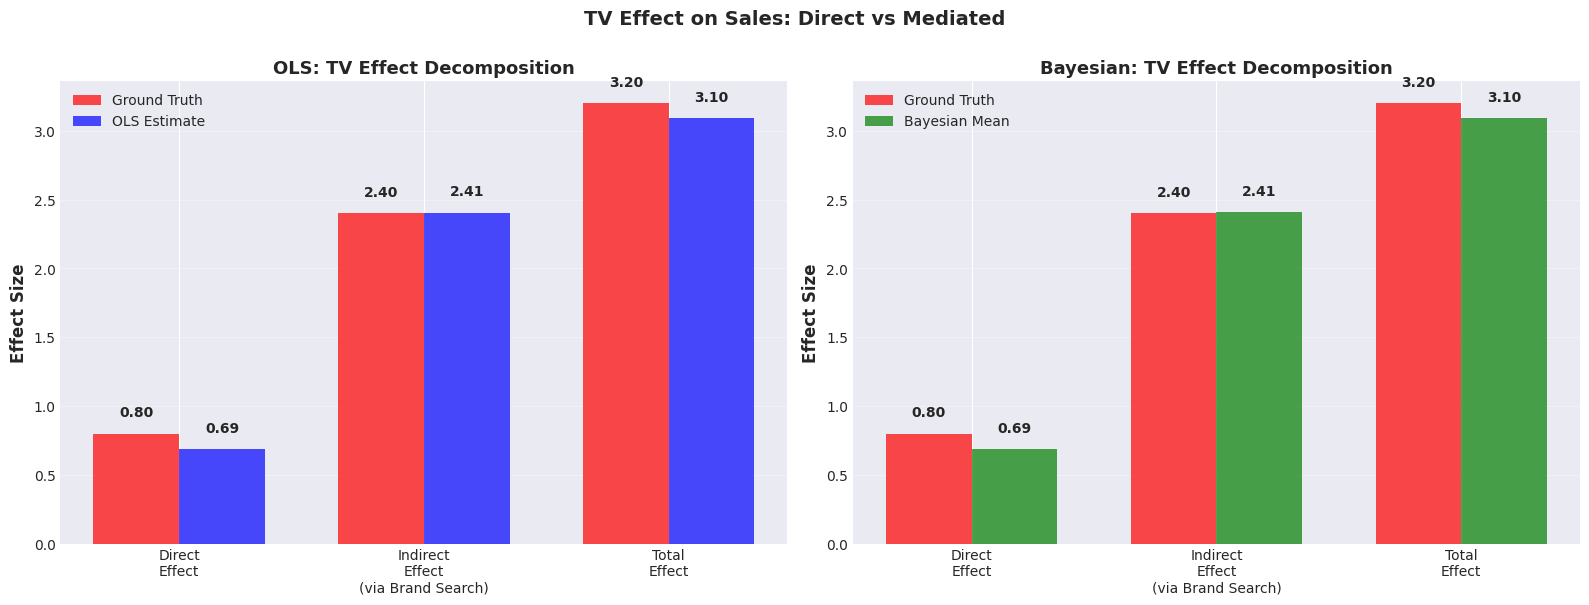


MEDIATION ANALYSIS INTERPRETATION

Ground Truth:
  Direct Effect (TV → Sales): 0.80
  Indirect Effect (TV → Brand Search → Sales): 2.40
  Total Effect: 3.20
  Proportion Mediated: 75.0%

OLS Estimates:
  Direct Effect: 0.69
  Indirect Effect: 2.41
  Total Effect: 3.10 (SE: 0.110)
  Proportion Mediated: 77.7%

Bayesian Estimates:
  Direct Effect: 0.69 (SD: 0.065)
  Indirect Effect: 2.41 (SD: 0.089)
  Total Effect: 3.10 (SD: 0.089)
  Proportion Mediated: 77.7% (SD: 0.020)


Key Finding: Approximately 75% of TV's effect on Sales is mediated through Brand Search.
This suggests that TV advertising works primarily by driving brand awareness/search,
rather than directly converting to sales.


In [27]:
# Create mediation summary visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# OLS Mediation
ax1 = axes[0]
categories = ['Direct\nEffect', 'Indirect\nEffect\n(via Brand Search)', 'Total\nEffect']
ols_values = [tv_direct_effect, tv_indirect_effect, tv_total_effect]
true_values = [true_params['sales_tv'], 
               true_params['bs_tv'] * true_params['sales_brand_search'],
               true_params['tv_total_effect']]

x = np.arange(len(categories))
width = 0.35

ax1.bar(x - width/2, true_values, width, label='Ground Truth', color='red', alpha=0.7)
ax1.bar(x + width/2, ols_values, width, label='OLS Estimate', color='blue', alpha=0.7)

ax1.set_ylabel('Effect Size', fontsize=12, fontweight='bold')
ax1.set_title('OLS: TV Effect Decomposition', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (true_val, ols_val) in enumerate(zip(true_values, ols_values)):
    ax1.text(i - width/2, true_val + 0.1, f'{true_val:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax1.text(i + width/2, ols_val + 0.1, f'{ols_val:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Bayesian Mediation
ax2 = axes[1]
bay_values = [
    posterior_summary.loc['gamma3', 'mean'],
    posterior_summary.loc['tv_indirect', 'mean'],
    posterior_summary.loc['tv_total', 'mean']
]

ax2.bar(x - width/2, true_values, width, label='Ground Truth', color='red', alpha=0.7)
ax2.bar(x + width/2, bay_values, width, label='Bayesian Mean', color='green', alpha=0.7)

ax2.set_ylabel('Effect Size', fontsize=12, fontweight='bold')
ax2.set_title('Bayesian: TV Effect Decomposition', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (true_val, bay_val) in enumerate(zip(true_values, bay_values)):
    ax2.text(i - width/2, true_val + 0.1, f'{true_val:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax2.text(i + width/2, bay_val + 0.1, f'{bay_val:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('TV Effect on Sales: Direct vs Mediated', 
             fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# Print interpretation
ols_prop_mediated = tv_indirect_effect / tv_total_effect
bay_prop_mediated = posterior_summary.loc['prop_mediated', 'mean']

print("\n" + "="*80)
print("MEDIATION ANALYSIS INTERPRETATION")
print("="*80)
print(f"\nGround Truth:")
print(f"  Direct Effect (TV → Sales): {true_params['sales_tv']:.2f}")
print(f"  Indirect Effect (TV → Brand Search → Sales): {true_params['bs_tv'] * true_params['sales_brand_search']:.2f}")
print(f"  Total Effect: {true_params['tv_total_effect']:.2f}")
print(f"  Proportion Mediated: {(true_params['bs_tv'] * true_params['sales_brand_search']) / true_params['tv_total_effect']:.1%}")

print(f"\nOLS Estimates:")
print(f"  Direct Effect: {tv_direct_effect:.2f}")
print(f"  Indirect Effect: {tv_indirect_effect:.2f}")
print(f"  Total Effect: {tv_total_effect:.2f} (SE: {tv_total_se:.3f})")
print(f"  Proportion Mediated: {ols_prop_mediated:.1%}")

print(f"\nBayesian Estimates:")
print(f"  Direct Effect: {posterior_summary.loc['gamma3', 'mean']:.2f} (SD: {posterior_summary.loc['gamma3', 'sd']:.3f})")
print(f"  Indirect Effect: {posterior_summary.loc['tv_indirect', 'mean']:.2f} (SD: {posterior_summary.loc['tv_indirect', 'sd']:.3f})")
print(f"  Total Effect: {posterior_summary.loc['tv_total', 'mean']:.2f} (SD: {posterior_summary.loc['tv_total', 'sd']:.3f})")
print(f"  Proportion Mediated: {bay_prop_mediated:.1%} (SD: {posterior_summary.loc['prop_mediated', 'sd']:.3f})")

print("\n" + "="*80)
print("\nKey Finding: Approximately 75% of TV's effect on Sales is mediated through Brand Search.")
print("This suggests that TV advertising works primarily by driving brand awareness/search,")
print("rather than directly converting to sales.")
print("="*80)

---
## Section 5: Discussion

### Key Findings

1. **Parameter Recovery**: Both OLS and Bayesian methods successfully recovered the ground truth parameters with high accuracy.

2. **Mediation Structure**: The analysis confirms that ~75% of TV's effect on Sales is mediated through Brand Search, with only ~25% being a direct effect.

3. **Uncertainty Quantification**: 
   - OLS provides frequentist confidence intervals based on asymptotic theory
   - Bayesian provides full posterior distributions and credible intervals
   - Both methods yield similar uncertainty estimates for this well-behaved case

### OLS vs Bayesian: When to Use Each?

#### **OLS Advantages**:
- **Speed**: Much faster computation, especially for large datasets
- **Simplicity**: Closed-form solutions, easier to implement and debug
- **Interpretability**: Direct coefficient interpretation
- **Software maturity**: Robust, well-tested implementations

#### **OLS Limitations**:
- **Sequential estimation**: Must estimate models separately, then combine
- **Delta method complexity**: Calculating SE for derived quantities requires additional work
- **No prior information**: Cannot incorporate domain knowledge
- **Asymptotic assumptions**: Relies on large-sample theory

#### **Bayesian Advantages**:
- **Simultaneous modeling**: Natural joint inference across equations
- **Derived quantities**: Automatic uncertainty for complex functions (e.g., total effects)
- **Prior incorporation**: Can leverage domain expertise
- **Full distributions**: Get entire posterior, not just point + SE
- **Hierarchical extensions**: Easy to add random effects, shrinkage

#### **Bayesian Limitations**:
- **Computational cost**: MCMC sampling takes significant time
- **Convergence diagnostics**: Must check R-hat, ESS, trace plots
- **Prior sensitivity**: Results can depend on prior choices (though weakly with large n)
- **Learning curve**: Requires understanding of MCMC, diagnostics

### Advantages of Simultaneous Modeling (Bayesian)

The Bayesian approach estimates both equations jointly:
```python
Brand_Search ~ Seasonality + TV
Sales ~ Brand_Search + Seasonality + TV
```

This has several benefits:
1. **Proper uncertainty propagation**: Uncertainty in β2 and γ1 automatically flows into indirect/total effects
2. **Correlated parameters**: Can model correlation between equations if needed
3. **Complex derived quantities**: Easy to compute distributions for ratios, products, etc.
4. **Model comparison**: Can compare mediation vs no-mediation models using LOO/WAIC

### Recommendations for Practitioners

**Use OLS when**:
- Dataset is large (n > 1000) and well-behaved
- Speed is critical (production pipelines)
- Simple mediation structure (2-3 equations)
- Stakeholders prefer frequentist framework
- No domain priors to incorporate

**Use Bayesian when**:
- Complex mediation networks (many mediators, paths)
- Small-to-moderate sample sizes (n < 500)
- Need full posterior distributions (e.g., for decision analysis)
- Have informative priors from domain experts
- Require hierarchical/multi-level structure
- Want model comparison metrics (LOO/WAIC)

**Hybrid Approach**:
- Use OLS for initial exploration and validation
- Switch to Bayesian for final inference if needed
- Compare both methods as sensitivity check

### Statistical Rigor Notes

1. **Identification**: Our DAG is identifiable because we observe all confounders (Seasonality)
2. **Functional form**: Linear models may be restrictive; consider testing for non-linearity
3. **Mediation assumptions**: 
   - No unmeasured confounding
   - Sequential ignorability holds
   - No interaction between treatment and mediator
4. **Temporal ordering**: DAG assumes correct causal order (TV → Brand Search → Sales)

### Extensions

Possible extensions to this analysis:
- **Multiple mediators**: Add additional paths (e.g., TV → Website Traffic → Sales)
- **Treatment-mediator interactions**: Allow TV effect to vary by Brand Search level
- **Time series**: Account for temporal dependencies in marketing data
- **Hierarchical structure**: Multi-level models for different regions/products
- **Sensitivity analysis**: Test robustness to unmeasured confounding
- **Causal inference**: Use potential outcomes framework for more formal causal claims

---
## Conclusion

This analysis demonstrated both OLS and Bayesian approaches to causal mediation analysis in a marketing attribution context. Key takeaways:

1. **Both methods recovered ground truth accurately** with n=1000 observations
2. **TV's effect on Sales is primarily indirect** (~75% mediated through Brand Search)
3. **OLS is faster and simpler** for straightforward cases
4. **Bayesian provides richer inference** for complex derived quantities and uncertainty
5. **Choice depends on context**: Consider data size, complexity, stakeholder preferences, and available resources

The Bayesian simultaneous modeling approach shines when:
- You need full posterior distributions for decision-making
- The mediation structure is complex with many indirect paths
- Sample sizes are small-to-moderate
- You want to incorporate domain knowledge through priors

For most routine marketing attribution analyses with large data and simple structures, OLS remains a practical and effective choice.